In [1]:
# Pip install
!pip install tiktoken

In [2]:
# Importing libraries
import os
import sys
import copy
import json
import time
import math
import torch
import random
import tiktoken
import torch.nn as nn
from torch.optim import AdamW
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datasets import DatasetDict
from datasets import load_dataset
from dataclasses import dataclass
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import PreTrainedModel
from transformers import PretrainedConfig

2026-02-09 09:36:17.470366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770629777.491577     826 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770629777.498013     826 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770629777.514815     826 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770629777.514833     826 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770629777.514835     826 computation_placer.cc:177] computation placer alr

In [3]:
# Git clone base model repository
!git clone https://huggingface.co/spaces/samkeet/GPT_124M

fatal: destination path 'GPT_124M' already exists and is not an empty directory.


In [4]:
# Model code
class GPTConfig(PretrainedConfig):
    model_type = "custom_gpt"

    def __init__(
        self,
        block_size: int = 1024,
        vocab_size: int = 50304,
        n_layer: int = 12,
        n_head: int = 12,
        n_embd: int = 768,
        **kwargs,
    ):
        """
        GPT configuration dataclass storing model hyperparameters.
        """
        super().__init__(**kwargs)
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.n_layer: int = n_layer
        self.n_head: int = n_head
        self.n_embd: int = n_embd

class GPT(nn.Module):
    """
    The GPT language model:
    - Embeddings (token + positional)
    - Stack of Transformer blocks
    - Final LayerNorm + Linear head for output logits
    """

    def __init__(
        self,
        block_size: int = 1024,
        vocab_size: int = 50304,
        n_layer: int = 12,
        n_head: int = 12,
        n_embd: int = 768,
    ):
        super().__init__()

        # Store model hyperparameters
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.n_layer = n_layer
        self.n_head = n_head
        self.n_embd = n_embd

        # Transformer components stored in a module dictionary
        self.transformer = nn.ModuleDict(
            dict(
                wte=nn.Embedding(self.vocab_size, self.n_embd),  # Token embedding
                wpe=nn.Embedding(self.block_size, self.n_embd),  # Positional embedding
                h=nn.ModuleList(
                    [self.Block(self.n_embd, self.n_head) for _ in range(self.n_layer)]
                ),  # Transformer blocks
                ln_f=nn.LayerNorm(self.n_embd),  # Final layer normalization
            )
        )

        # Linear head for output logits
        self.lm_head = nn.Linear(self.n_embd, self.vocab_size, bias=False)

        # Tie weights between token embedding and output projection
        self.transformer.wte.weight = self.lm_head.weight

    def forward(self, x):
        B, T = x.shape  # Batch size and sequence length
        assert T <= self.block_size, "Cannot forward sequence longer than block size"

        # Token and positional embeddings
        tok_emb = self.transformer.wte(x)
        pos_emb = self.transformer.wpe(torch.arange(T, device=x.device))
        x = tok_emb + pos_emb.unsqueeze(0)

        # Forward pass through transformer blocks
        for block in self.transformer.h:
            x = block(x)

        x = self.transformer.ln_f(x)  # Final layer norm
        logits = self.lm_head(x)  # Compute logits
        return logits

    class CausalSelfAttention(nn.Module):
        """
        Multi-head self-attention with causal masking.
        """

        def __init__(self, n_embd, n_head):
            super().__init__()
            assert (
                n_embd % n_head == 0
            ), "Embedding dimension must be divisible by number of heads"
            self.n_head = n_head
            self.n_embd = n_embd

            # Linear layers for query, key, and value
            self.c_attn = nn.Linear(n_embd, 3 * n_embd)
            self.c_proj = nn.Linear(n_embd, n_embd)

        def forward(self, x):
            B, T, C = x.size()
            qkv = self.c_attn(x)
            q, k, v = qkv.split(self.n_embd, dim=2)

            # Reshape and transpose for multi-head attention
            k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
            q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
            v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

            # Apply scaled dot-product attention with causal masking
            y = F.scaled_dot_product_attention(q, k, v, is_causal=True)

            # Reshape and apply output projection
            y = y.transpose(1, 2).contiguous().view(B, T, C)
            y = self.c_proj(y)
            return y

    class MLP(nn.Module):
        """
        Feed-forward network block used in Transformer architectures.
        """

        def __init__(self, n_embd):
            super().__init__()
            self.c_fc = nn.Linear(n_embd, 4 * n_embd)
            self.gelu = nn.GELU(approximate="tanh")
            self.c_proj = nn.Linear(4 * n_embd, n_embd)

        def forward(self, x):
            return self.c_proj(self.gelu(self.c_fc(x)))

    class Block(nn.Module):
        """
        A single Transformer block.
        """

        def __init__(self, n_embd, n_head):
            super().__init__()
            self.ln_1 = nn.LayerNorm(n_embd)
            self.attn = GPT.CausalSelfAttention(n_embd, n_head)
            self.ln_2 = nn.LayerNorm(n_embd)
            self.mlp = GPT.MLP(n_embd)

        def forward(self, x):
            x = x + self.attn(self.ln_1(x))
            x = x + self.mlp(self.ln_2(x))
            return x


class GPTModelForTextGeneration(PreTrainedModel):
    """
    A wrapper class for GPT-based text generation.
    This integrates a Transformer model within the Hugging Face `PreTrainedModel` framework.
    """

    config_class = GPTConfig

    def __init__(self, config):
        super().__init__(config)

        # Instantiate the GPT model with the provided configuration
        self.model = GPT(
            block_size=config.block_size,
            vocab_size=config.vocab_size,
            n_layer=config.n_layer,
            n_head=config.n_head,
            n_embd=config.n_embd,
        )

    def forward(self, input_ids: torch.Tensor):
        # Check input_ids type and shape
        assert isinstance(input_ids, torch.Tensor), "input_ids must be a PyTorch tensor"

        tokens = input_ids.clone()  # Avoid modifying input_ids directly
        tokens = tokens.unsqueeze(0) if tokens.dim() == 1 else tokens

        assert (
            tokens.ndim == 2 and tokens.shape[0] == 1
        ), "input_ids must have 2 dimensions: (1, sequence_length)"

        # Check token values
        assert torch.all(
            (tokens >= 0) & (tokens <= self.model.vocab_size)
        ), "input_ids contain invalid token values"

        # Forward pass through the model
        logits = self.model.forward(tokens)

        return {"logits": logits}

    @torch.no_grad()
    def generate(
        self,
        input_ids: torch.Tensor,
        max_length: int = 50,
        do_sample: bool = True,
        top_k: int = 50,
        top_p: float = 0.95,
        temperature: float = 0.9,
        device: str = "cpu",
    ):
        """
        Generates text using autoregressive sampling with top-k, top-p, and temperature.
        """

        # Validate device type
        if device.startswith("cuda"):
            assert torch.cuda.is_available(), "CUDA is not available, please use 'cpu'"
            if device != "cuda":  # Check for specific CUDA device (cuda:n)
                try:
                    device_index = int(device.split(":")[1])  # Extract device number
                    assert (
                        0 <= device_index < torch.cuda.device_count()
                    ), f"Invalid CUDA device index: {device_index}"
                except (IndexError, ValueError):
                    raise ValueError(
                        "Invalid device format. Use 'cpu', 'cuda', or 'cuda:N' where N is an integer."
                    )
        elif device != "cpu":
            raise ValueError("Invalid device. Use 'cpu', 'cuda', or 'cuda:N'.")

        # Move input tensor and model to the specified device
        input_ids = input_ids.to(device)
        self.model.to(device)

        # Check input_ids type and shape
        assert isinstance(input_ids, torch.Tensor), "input_ids must be a PyTorch tensor"
        tokens = input_ids.clone()  # Avoid modifying input_ids directly
        tokens = tokens.unsqueeze(0) if tokens.dim() == 1 else tokens

        assert (
            tokens.ndim == 2 and tokens.shape[0] == 1
        ), "input_ids must have 2 dimensions: (1, sequence_length)"

        # Check token values
        assert torch.all(
            (tokens >= 0) & (tokens < self.model.vocab_size)
        ), "input_ids contain invalid token values"

        # Check max_length
        assert (
            isinstance(max_length, int) and max_length >= 1
        ), "max_length must be a positive integer"
        assert (
            max_length <= self.model.block_size
        ), f"max_length must be in range [1, {self.model.block_size}]"

        # Check top_k
        assert isinstance(top_k, int) and top_k >= 1, "top_k must be a positive integer"

        # Check top_p
        assert (
            isinstance(top_p, (int, float)) and 0.0 <= top_p <= 1.0
        ), "top_p must be in range [0, 1]"

        # Check temperature
        assert (
            isinstance(temperature, (int, float)) and 0.0 <= temperature <= 1.0
        ), "temperature must be in range [0, 1]"

        # Move tokens to the correct device
        tokens = tokens.to(device)

        # Autoregressive token generation loop
        while tokens.size(1) < max_length:
            logits = self.forward(tokens)["logits"][:, -1, :]
            logits = logits / max(0.01, temperature)

            if do_sample:
                top_k = min(top_k, logits.size(-1))  # Safety check

                # Remove all tokens with a probability less than the last token of the top-k
                indices_to_remove = (
                    logits < torch.topk(logits, top_k, dim=1)[0][..., -1, None]
                )
                logits[indices_to_remove] = float("-inf")

                sorted_logits, sorted_indices = torch.sort(logits, descending=True)

                cumulative_probs = torch.cumsum(
                    F.softmax(sorted_logits, dim=-1), dim=-1
                )
                # Remove tokens with cumulative probability above the threshold
                sorted_indices_to_remove = cumulative_probs > top_p
                # Shift the indices to the right to keep also the first token above the threshold
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                    ..., :-1
                ].clone()
                sorted_indices_to_remove[..., 0] = 0

                # Replace logits to be removed with -inf in the sorted_logits
                sorted_logits[sorted_indices_to_remove] = float("-inf")
                # Then reverse the sorting process by mapping back sorted_logits to their original position
                logits = torch.gather(sorted_logits, 1, sorted_indices.argsort(-1))

                # Convert sorted indices back to original vocab indices
                next_tokens = torch.multinomial(F.softmax(logits, -1), 1)
            else:
                next_tokens = torch.argmax(logits, dim=-1, keepdim=True)

            tokens = torch.cat((tokens, next_tokens), dim=1)

        return tokens.flatten()

In [5]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Load config
config_path = "/kaggle/working/GPT_124M/GPT_124M/config.json"

with open(config_path, "r") as f:
    cfg_dict = json.load(f)

config = GPTConfig(**cfg_dict)

In [7]:
# Base model
model = GPT(
    block_size=config.block_size,
    vocab_size=config.vocab_size,
    n_layer=config.n_layer,
    n_head=config.n_head,
    n_embd=config.n_embd,
  )

In [8]:
# Load PyTorch weights
state_dict_path = "/kaggle/working/GPT_124M/GPT_124M/pytorch_model.bin"
state_dict = torch.load(state_dict_path, map_location="cpu")

# Strip "model." prefix
new_state_dict = {}
for k, v in state_dict.items():
    if k.startswith("model."):
        new_state_dict[k[len("model."):]] = v
    else:
        new_state_dict[k] = v

missing, unexpected = model.load_state_dict(new_state_dict, strict=True)
model.to(device)

print("Missing keys:", missing)
print("Unexpected keys:", unexpected)
print(model)

Missing keys: []
Unexpected keys: []
GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50304, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='tanh')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50304, bias=False)
)


In [9]:
# Tokenizer
tokenizer = tiktoken.get_encoding("gpt2")

EOS_TOKEN = tokenizer.eot_token
print("EOS_TOKEN id:", EOS_TOKEN)
print("EOS_TOKEN text:", tokenizer.decode([EOS_TOKEN]))

EOS_TOKEN id: 50256
EOS_TOKEN text: <|endoftext|>


In [10]:
# Model sanity-check
@torch.no_grad()
def model_sanity_check(model, tokenizer, device, prompt, max_new_tokens=50):
    model.eval()
    ids = tokenizer.encode(prompt)
    x = torch.tensor(ids, device=device).unsqueeze(0)

    for _ in range(max_new_tokens):
        logits = model(x)[:, -1, :]
        next_id = torch.argmax(logits, dim=-1, keepdim=True)
        x = torch.cat([x, next_id], dim=1)

        if next_id.item() == EOS_TOKEN:
            break

    return tokenizer.decode(x[0].tolist())

prompt = "The Earth revolves around"
print(model_sanity_check(model, tokenizer, device, prompt))

The Earth revolves around the Sun, and the Moon revolves around the Earth.
The Earth is the center of the solar system, and the Moon is the center of the solar system.
The Earth is the center of the solar system, and the Moon is the center


In [11]:
# LoRA Linear Layer
class LoRALinear(nn.Module):
    def __init__(
        self,
        base_layer: nn.Linear,
        r: int = 8,
        lora_alpha: int = 8,
        lora_dropout: float = 0.05,
    ):
        super().__init__()

        assert isinstance(base_layer, nn.Linear)

        self.base_layer = base_layer
        self.r = r
        self.lora_alpha = lora_alpha
        self.scaling = lora_alpha / r
        self.dropout = nn.Dropout(lora_dropout) if lora_dropout > 0 else nn.Identity()

        in_features = base_layer.in_features
        out_features = base_layer.out_features

        # Freeze base weights
        self.base_layer.weight.requires_grad = False
        if self.base_layer.bias is not None:
            self.base_layer.bias.requires_grad = False

        # LoRA weights
        self.lora_A = nn.Parameter(torch.zeros(r, in_features))
        self.lora_B = nn.Parameter(torch.zeros(out_features, r))

        # Init
        nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
        nn.init.zeros_(self.lora_B)

    def forward(self, x):
        result = self.base_layer(x)
        lora_out = (
            self.dropout(x)
            @ self.lora_A.T
            @ self.lora_B.T
        ) * self.scaling
        return result + lora_out

In [12]:
# Inject LoRA into your GPT model
def apply_lora_to_gpt(model, r, alpha, dropout):
    for block in model.transformer.h:
        # Attention
        block.attn.c_attn = LoRALinear(
            block.attn.c_attn, r=r, lora_alpha=alpha, lora_dropout=dropout
        )
        block.attn.c_proj = LoRALinear(
            block.attn.c_proj, r=r, lora_alpha=alpha, lora_dropout=dropout
        )

        # MLP
        block.mlp.c_fc = LoRALinear(
            block.mlp.c_fc, r=r, lora_alpha=alpha, lora_dropout=dropout
        )
        block.mlp.c_proj = LoRALinear(
            block.mlp.c_proj, r=r, lora_alpha=alpha, lora_dropout=dropout
        )

In [13]:
# # Inject LoRA into your GPT model
# apply_lora_to_gpt(model, r=8, alpha=8, dropout=0.05)

In [14]:
# # Freeze model
# def mark_only_lora_as_trainable(model):
#     for name, param in model.named_parameters():
#         if "lora_" in name:
#             param.requires_grad = True
#         else:
#             param.requires_grad = False

# def make_more_trainable(model, last_n_blocks=2):
#     # Unfreeze last N transformer blocks
#     for block in model.transformer.h[-last_n_blocks:]:
#         for p in block.parameters():
#             p.requires_grad = True

#     # Unfreeze final LayerNorm
#     for p in model.transformer.ln_f.parameters():
#         p.requires_grad = True

#     # Unfreeze LM head
#     for p in model.lm_head.parameters():
#         p.requires_grad = True

# # Freeze model
# mark_only_lora_as_trainable(model)
# make_more_trainable(model, last_n_blocks=2)

In [15]:
# Train full model
for name, param in model.named_parameters():
    param.requires_grad = True

In [16]:
# Trainable params
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {trainable:,} / {total:,} ({trainable/total * 100}%)")

Trainable params: 124,475,904 / 124,475,904 (100.0%)


In [17]:
# Download and cache the dataset locally
DATA_DIR = "./data/alpaca"
os.makedirs(DATA_DIR, exist_ok=True)

dataset = load_dataset(
    "tatsu-lab/alpaca",
    cache_dir=DATA_DIR,
)

# Inspect dataset structure
print(dataset)
print(dataset["train"][0])

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-a09b74b3ef9c3b(…):   0%|          | 0.00/24.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/52002 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output', 'text'],
        num_rows: 52002
    })
})
{'instruction': 'Give three tips for staying healthy.', 'input': '', 'output': '1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. \n2. Exercise regularly to keep your body active and strong. \n3. Get enough sleep and maintain a consistent sleep schedule.', 'text': 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nGive three tips for staying healthy.\n\n### Response:\n1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. \n2. Exercise regularly to keep your body active and strong. \n3. Get enough sleep and maintain a consistent sleep schedule.'}


In [18]:
# Text Builder
def build_text(example):
    instruction = example["instruction"].strip()
    input_text = example["input"].strip()
    output = example["output"].strip()

    if input_text:
        instruction = f"{instruction}\n\n{input_text}".strip()

    prompt = (
        "### Instruction:\n"
        f"{instruction}\n\n"
        "### Response:\n"
    )

    return prompt, output

In [26]:
# Filter lengthy examples
BLOCK_SIZE = config.block_size

# Count total tokens (prompt + response + EOS)
def count_tokens(example):
    prompt, response = build_text(example)
    return (
        len(tokenizer.encode(prompt)) +
        len(tokenizer.encode(response)) + 1  # EOS token
    )

# Filter out examples longer than model context
filtered_train = dataset["train"].filter(
    lambda ex: count_tokens(ex) <= BLOCK_SIZE
)

print("Filtered train size:", len(filtered_train))

# Create train / test split from Alpaca train set
dataset = DatasetDict(
    filtered_train.train_test_split(
        test_size=0.1,
        shuffle=True,
        seed=0
    )
)

print(dataset)

Filter:   0%|          | 0/46800 [00:00<?, ? examples/s]

Filtered train size: 46800
DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output', 'text'],
        num_rows: 42120
    })
    test: Dataset({
        features: ['instruction', 'input', 'output', 'text'],
        num_rows: 4680
    })
})


In [27]:
# Dataset
class InstructionDataset(Dataset):
    def __init__(self, dataset, tokenizer, eos_token):
        self.data = dataset
        self.tokenizer = tokenizer
        self.eos_token = eos_token

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        prompt, response = build_text(example)

        prompt_ids = self.tokenizer.encode(prompt)
        response_ids = self.tokenizer.encode(response) + [self.eos_token]

        input_ids = prompt_ids + response_ids
        labels = [-100] * len(prompt_ids) + response_ids

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "labels": torch.tensor(labels, dtype=torch.long),
        }

In [28]:
# Collate function
def collate_fn(batch, block_size, pad_token_id):
    input_ids, labels = [], []

    for item in batch:
        ids = item["input_ids"]
        lbls = item["labels"]

        ids = ids[:-1]
        lbls = lbls[1:]

        if len(ids) > block_size:
            ids = ids[-block_size:]
            lbls = lbls[-block_size:]

        pad_len = block_size - len(ids)

        ids = torch.cat([
            ids,
            torch.full((pad_len,), pad_token_id, dtype=torch.long),
        ])

        lbls = torch.cat([
            lbls,
            torch.full((pad_len,), -100, dtype=torch.long),
        ])

        input_ids.append(ids)
        labels.append(lbls)

    return {
        "input_ids": torch.stack(input_ids),
        "labels": torch.stack(labels),
    }

In [29]:
# Config
@dataclass
class TrainConfig:
    # Data
    batch_size: int = 8
    block_size: int = BLOCK_SIZE
    epochs: int = 3

    # Optimization
    lr: float = 5e-5
    weight_decay: float = 0.1
    betas: tuple = (0.9, 0.999)

    # Schedule
    warmup_pct: float = 0.01

    # Logging and saving
    log_every: int = 10
    save_every: int = 200
    output_dir: str = "./checkpoints"

    # Generation
    gen_max_tokens: int = BLOCK_SIZE
    gen_samples: int = 5

# Compute derived training values
def finalize_train_config(cfg: TrainConfig, train_dataset_len: int):
    steps_per_epoch = train_dataset_len // cfg.batch_size
    total_steps = steps_per_epoch * cfg.epochs
    warmup_steps = max(1, int(total_steps * cfg.warmup_pct))

    cfg.steps_per_epoch = steps_per_epoch
    cfg.total_steps = total_steps
    cfg.warmup_steps = warmup_steps

    return cfg

In [30]:
# Train and test data
train_dataset = dataset["train"]
test_dataset = dataset["test"]

train_ds = InstructionDataset(
    dataset=train_dataset,
    tokenizer=tokenizer,
    eos_token=EOS_TOKEN
)

test_ds = InstructionDataset(
    dataset=test_dataset,
    tokenizer=tokenizer,
    eos_token=EOS_TOKEN
)

In [31]:
# Training config
cfg = TrainConfig()
cfg = finalize_train_config(cfg, len(train_ds))

In [32]:
# DataLoader
train_loader = DataLoader(
    train_ds,
    batch_size=cfg.batch_size,
    shuffle=True,
    collate_fn=lambda b: collate_fn(b, cfg.block_size, EOS_TOKEN),
    pin_memory=True,
)

test_loader = DataLoader(
    test_ds,
    batch_size=cfg.batch_size,
    shuffle=False,
    collate_fn=lambda b: collate_fn(b, cfg.block_size, EOS_TOKEN),
)

In [33]:
# Print training info
os.makedirs(cfg.output_dir, exist_ok=True)

print("========== TRAIN CONFIG ==========")
for k, v in vars(cfg).items():
    print(f"{k}: {v}")

print("\n========== MODEL ARCHITECTURE ==========")
print(model)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("\n========== PARAMETERS ==========")
print(f"Total params:     {total_params:,}")
print(f"Trainable params: {trainable_params:,}")
print(f"Trainable %:      {100 * trainable_params / total_params:.2f}%")

========== TRAIN CONFIG ==========
batch_size: 8
block_size: 1024
epochs: 3
lr: 5e-05
weight_decay: 0.1
betas: (0.9, 0.999)
warmup_pct: 0.01
log_every: 10
save_every: 200
output_dir: ./checkpoints
gen_max_tokens: 1024
gen_samples: 5
steps_per_epoch: 5265
total_steps: 15795
warmup_steps: 157

========== MODEL ARCHITECTURE ==========
GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50304, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='tanh')
          (c_proj): Linear(in_features=3072, out_fe

In [34]:
# Optimizer and warmup cosine LR scheduler
optimizer = AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=cfg.lr,
    betas=cfg.betas,
    weight_decay=cfg.weight_decay,
)

In [35]:
# Warmup and cosine
def get_lr(step, cfg):
    if step < cfg.warmup_steps:
        return cfg.lr * step / max(1, cfg.warmup_steps)

    progress = (step - cfg.warmup_steps) / max(
        1, cfg.total_steps - cfg.warmup_steps
    )
    return 0.5 * cfg.lr * (1.0 + math.cos(math.pi * progress))

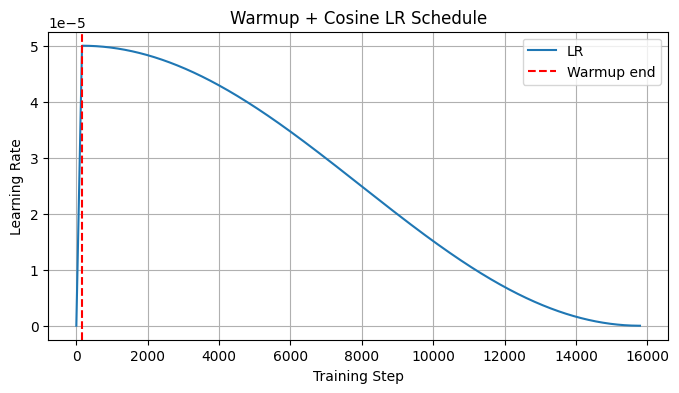

In [36]:
# Plot LR
lrs = [get_lr(step, cfg) for step in range(cfg.total_steps)]
steps = list(range(cfg.total_steps))

plt.figure(figsize=(8, 4))
plt.plot(steps, lrs, label="LR")
plt.axvline(cfg.warmup_steps, color="red", linestyle="--", label="Warmup end")
plt.xlabel("Training Step")
plt.ylabel("Learning Rate")
plt.title("Warmup + Cosine LR Schedule")
plt.legend()
plt.grid(True)
plt.show()

In [37]:
# Generation helper for random samples
@torch.no_grad()
def generate_from_prompt(model, tokenizer, device, prompt, max_tokens):
    model.eval()

    ids = tokenizer.encode(prompt)
    x = torch.tensor(ids, device=device).unsqueeze(0)

    max_new_tokens = max_tokens - x.size(1)
    if max_new_tokens <= 0:
        return tokenizer.decode(x[0].tolist())

    for _ in range(max_new_tokens):
        logits = model(x)[:, -1, :]
        # next_id = torch.argmax(logits, dim=-1, keepdim=True)
        probs = F.softmax(logits / 0.8, dim=-1)
        next_id = torch.multinomial(probs, 1)
        x = torch.cat([x, next_id], dim=1)

        if next_id.item() == EOS_TOKEN:
            break

    return tokenizer.decode(x[0].tolist())

In [38]:
# Print Prompt / Model Output / Ground Truth
def print_test_example(model, tokenizer, device, test_dataset, max_tokens, idx):
    # Pick random example if idx not provided
    if idx is None:
        idx = random.randint(0, len(test_dataset) - 1)

    example = test_dataset[idx]

    prompt, _ = build_text(example)
    target = example["output"].strip()

    full_output = generate_from_prompt(
        model,
        tokenizer,
        device,
        prompt,
        max_tokens
    )

    if full_output.startswith(prompt):
      model_output = full_output[len(prompt):].lstrip()
    else:
      model_output = full_output.strip()

    print("=" * 80)
    print(f"TEST EXAMPLE #{idx}")
    print("=" * 80)

    print("\n🟦 PROMPT:")
    print(prompt)

    print("\n🟨 MODEL OUTPUT:")
    print(model_output)

    print("\n🟩 GROUND TRUTH:")
    print(target)

    print("=" * 80)

# Print N random test examples
def print_random_test_samples(model, tokenizer, device, test_dataset, max_tokens, n):
    for _ in range(n):
        print_test_example(
            model,
            tokenizer,
            device,
            test_dataset,
            max_tokens,
            None
        )

In [39]:
# Merge LoRA weights into base Linear layers and remove LoRA modules
def merge_lora_weights(model):
    for name, module in list(model.named_modules()):
        if hasattr(module, "lora_A") and hasattr(module, "lora_B"):
            # module is LoRALinear
            base = module.base_layer

            # W <- W + (B @ A) * scaling
            delta_w = (module.lora_B @ module.lora_A) * module.scaling
            base.weight.data += delta_w.to(base.weight.device)

            # Replace LoRALinear with the base Linear
            parent = model
            path = name.split(".")
            for p in path[:-1]:
                parent = getattr(parent, p)
            setattr(parent, path[-1], base)

In [40]:
# Cross entropy loss calculation
def calc_loss_batch(input_ids, labels, model, device):     
    logits = model(input_ids)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), 
        labels.flatten(),
        ignore_index=-100
    )
    return loss

In [41]:
# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

loss_history = []
start_time = time.time()
step_times = []

step = 0
while step < cfg.total_steps:
    for batch in train_loader:
        if step >= cfg.total_steps:
            break

        t0 = time.time()

        # LR schedule
        lr = get_lr(step, cfg)
        for pg in optimizer.param_groups:
            pg["lr"] = lr

        # Zero grad optimizer
        optimizer.zero_grad()
        
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)

        # Loss
        loss = calc_loss_batch(
            input_ids, 
            labels, 
            model, 
            device
        )
        loss.backward()

        # Optimizer
        torch.nn.utils.clip_grad_norm_(
            [p for p in model.parameters() if p.requires_grad],
            max_norm=1.0
        )
        optimizer.step()

        # Logging
        loss_history.append(loss.item())
        step_times.append(time.time() - t0)

        if step % cfg.log_every == 0:
            avg_step = sum(step_times[-cfg.log_every:]) / max(1, len(step_times[-cfg.log_every:]))
            eta = avg_step * (cfg.total_steps - step)

            print(
                f"[Step {step:5d}] "
                f"Loss={loss.item():.4f} "
                f"Learning Rate={lr:.2e} "
                f"Average Step={avg_step:.3f}s "
                f"ETA={eta/60:.1f} min"
            )

        # Save and sample
        if step > 0 and step % cfg.save_every == 0:
            ckpt_path = f"{cfg.output_dir}/model_lora.pt"
            torch.save(model.state_dict(), ckpt_path)
            print(f"Saved LoRA checkpoint: {ckpt_path}")

            print("\n=== RANDOM GENERATIONS ===")
            print_random_test_samples(
                model=model,
                tokenizer=tokenizer,
                device=device,
                test_dataset=test_dataset,
                n=cfg.gen_samples,
                max_tokens=cfg.gen_max_tokens,
            )
            model.train()

            # Clear CUDA cache
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                
        step += 1

[Step     0] Loss=2.3203 Learning Rate=0.00e+00 Average Step=1.276s ETA=336.0 min
[Step    10] Loss=2.3573 Learning Rate=3.18e-06 Average Step=1.097s ETA=288.7 min
[Step    20] Loss=2.5998 Learning Rate=6.37e-06 Average Step=1.097s ETA=288.4 min
[Step    30] Loss=2.1286 Learning Rate=9.55e-06 Average Step=1.099s ETA=288.8 min
[Step    40] Loss=2.1293 Learning Rate=1.27e-05 Average Step=1.098s ETA=288.3 min
[Step    50] Loss=1.8777 Learning Rate=1.59e-05 Average Step=1.100s ETA=288.6 min
[Step    60] Loss=1.4974 Learning Rate=1.91e-05 Average Step=1.100s ETA=288.5 min
[Step    70] Loss=2.3096 Learning Rate=2.23e-05 Average Step=1.098s ETA=287.7 min
[Step    80] Loss=2.6923 Learning Rate=2.55e-05 Average Step=1.097s ETA=287.3 min
[Step    90] Loss=2.2706 Learning Rate=2.87e-05 Average Step=1.098s ETA=287.4 min
[Step   100] Loss=2.2385 Learning Rate=3.18e-05 Average Step=1.100s ETA=287.8 min
[Step   110] Loss=1.9683 Learning Rate=3.50e-05 Average Step=1.100s ETA=287.6 min
[Step   120] Los

In [43]:
# Save final model
os.makedirs(cfg.output_dir, exist_ok=True)
final_path = os.path.join(cfg.output_dir, "model_gpt2_instruct.pt")
torch.save(model.state_dict(), final_path)
print(f"Saved final model to: {final_path}")

Saved final model to: ./checkpoints/model_gpt2_instruct.pt


In [42]:
# Clone model
merged_model = copy.deepcopy(model).cpu()

# Merge LoRA into base weights
merge_lora_weights(merged_model)

# Save merged model
ckpt_path = f"{cfg.output_dir}/model_instruct.pt"
torch.save(merged_model.state_dict(), ckpt_path)

print(f"Saved merged base model: {ckpt_path}")

Saved merged base model: ./checkpoints/model_instruct.pt
